**Official implementation of paper "Revisiting In-context Learning Inference Circuit in Large Language Models" (ICLR 2025)**:

### Source code for the Experiment 1 for Figure 2 Left and Middle.

This experiment is to calculate the kernel alignment between the ICL hidden states and the sentence embedding. Control the parameters differently will make you get the Fig. 2 Left (by `ICL_selected_token_type`) and Middle (by `k`).

Author: Hakaze Cho, yfzhao@jaist.ac.jp

Organized and modified by: Hakaze Cho, 2025/01/26

**Part I: Import, Define, and Load Everything**

What you should do:
1. [Cell 1] Change to the path from your working directory to the directory containing the README.md file.
2. [Cell 2] Define your experiment parameters.
3. Run the Cell 1 and Cell 2.


In [13]:
# Cell 1: Import libraries and change the working directory.

## Import libraries
import os
from util import load_model_and_data, kernel_alignment, inference
import StaICC
import matplotlib.pyplot as plt

## Change the working directory
try:
    # Change to the path from your working directory to the directory containing the README.md file.
    os.chdir("ICL_Inference_Dynamics_Released") 
except:
    print("Already in the correct directory or the directory does not exist.")

## Some definations for the plots.
plt.style.use('default')
plt.rc('font',family='Cambria Math')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Cambria Math'] + plt.rcParams['font.serif']

Already in the correct directory or the directory does not exist.


In [2]:
# Cell 2: Model and huggingfacetoken configurations

## The huggingface model name to be tested as the LM for ICL. 
## Recommended: "meta-llama/Meta-Llama-3-8B", "EleutherAI/pythia-6.9b", "tiiuae/falcon-7b", "meta-llama/Meta-Llama-3-70B", "tiiuae/falcon-40b"
ICL_model_name = "tiiuae/falcon-40b" 

## Whether to use the quantized version of the model. 
## Recommended: Keep it default.
quantized = False if ICL_model_name in ["meta-llama/Meta-Llama-3-8B", "EleutherAI/pythia-6.9b", "tiiuae/falcon-7b"] else True

## The huggingface model name to be tested as the reference encoder.
## Recommended: "BAAI/bge-m3"
encoder_model_name = "BAAI/bge-m3"

## The huggingface token to access the model. If you use the Llama model, you need to set this.
huggingface_token = 'your token here'


# Experiment parameters

## The selected token type to calculate the KA. Alternative: "none" (natural ICL sample end), "label_words", "last_sentence_token".
ICL_selected_token_type = "label_words" 

## The demonstration numbers. Recommended: 0, 1, 2, 4, 8, 12.
k = 4 

## The used dataset index from the StaICC library. Alternative: 0, 1, 2, 3, 4, 5.
dataset_index = 2 

## The used dataset index from the StaICC library for the controlled experiment. Fixed to TEE (index 6).
pesudo_dataset_index = 7  

## Force the ICL_model to reload, even the ICL_model is already in the variables. 
## Recommended: False.
model_forced_reload = False

In [ ]:
# Cell 3: Load the data and build the test inputs.

benchmark = StaICC.Normal(k)
prompts, queries = load_model_and_data.load_data_from_StaICC_experimentor(benchmark[dataset_index], ICL_selected_token_type)
_, pesudo_queries = load_model_and_data.load_data_from_StaICC_experimentor(benchmark[pesudo_dataset_index])

Loading data...

1 in 10 Data loaded:  GLUE-SST2 

2 in 10 Data loaded:  rotten_tomatoes 

3 in 10 Data loaded:  financial_phrasebank 

4 in 10 Data loaded:  SST5 

5 in 10 Data loaded:  TREC 

6 in 10 Data loaded:  AGNews 

7 in 10 Data loaded:  Subjective 

8 in 10 Data loaded:  tweet_eval_emotion 

9 in 10 Data loaded:  tweet_eval_hate 

10 in 10 Data loaded:  hate_speech_18 

Data loaded successfully.

Initializing experimentor on k = 4...

Ready.



In [ ]:
# Cell 4: Load the models.

vars_dict = vars() if "ICL_model" in vars() else locals()
if "ICL_model" not in vars_dict or model_forced_reload:
    ICL_model, ICL_tknz = load_model_and_data.load_ICL_model(ICL_model_name, huggingface_token = huggingface_token, quantized = quantized)
    encoder_model, encoder_tknz = load_model_and_data.load_encode_model(encoder_model_name, huggingface_token = huggingface_token)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

/home/s2320415/anaconda3/envs/icl_circuit/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


**Part II: Run the Experiment**

What you should do:

1. Run the Cell 5 - 6.

In [5]:
# Cell 5: Get the ICL hidden states and the encoder features, also the pesudo encoder features from another dataset defined by the pesudo_dataset_index.

ICL_hidden_states = inference.ICL_inference_to_hidden_states(ICL_model, ICL_tknz, prompts)
encoder_feature = inference.encoder_inference_to_feature(encoder_model, encoder_tknz, queries)
pesudo_encoder_feature = inference.encoder_inference_to_feature(encoder_model, encoder_tknz, pesudo_queries)

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [00:05<00:00, 100.69it/s]


In [12]:
# Cell 6: Calculate the similarity map and the kernel alignment. Refer to `util/kernel_alignment.py` for more details.

## Calculate the similarity map (defined as $\delta: \mathcal{X}\rightarrow\mathbb{H}^{d}$ in the Appendix A.2).
ICL_sim_map = []
for layer_hidden_state in ICL_hidden_states:
    ICL_sim_map.append(kernel_alignment.sim_graph(layer_hidden_state))
encoder_sim_map = kernel_alignment.sim_graph(encoder_feature)
pesudo_encoder_sim_map = kernel_alignment.sim_graph(pesudo_encoder_feature)

## Calculate the kernel alignment.
### The organization of the results: res_kernel_alignment[layer_index]: (mean, std, individual_values)
res_kernel_alignment = []
res_reference_kernel_alignment = []
for layer_sim_graph in ICL_sim_map:
    res_kernel_alignment.append(kernel_alignment.kernel_alignment(layer_sim_graph, encoder_sim_map))
    res_reference_kernel_alignment.append(kernel_alignment.kernel_alignment(layer_sim_graph, pesudo_encoder_sim_map))

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [00:01<00:00, 336.22it/s]


**Part III: Plot and Save the Result**

What you should do:

1. Run the Cell 7 and 8. You can define your own file name and dictionary to save the result in Cell 8.

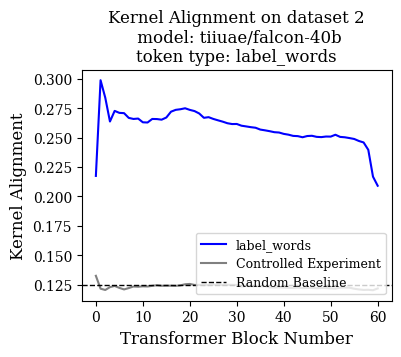

In [28]:
# Cell 7: Data preview.

avg_kernel_alignment_for_plot = []
avg_reference_kernel_alignment = []

for line in res_kernel_alignment:
    avg_kernel_alignment_for_plot.append(line[0])
for line in res_reference_kernel_alignment:
    avg_reference_kernel_alignment.append(line[0])

plt.figure(figsize=(4, 3))
plt.xlabel("Transformer Block Number", fontsize = 12)
plt.ylabel("Kernel Alignment", fontsize = 12)
plt.title("Kernel Alignment on dataset " + str(dataset_index) + "\n model: " + ICL_model_name + "\ntoken type: " + ICL_selected_token_type, fontsize = 12)
plt.plot(avg_kernel_alignment_for_plot, label=ICL_selected_token_type, color="blue")
plt.plot(avg_reference_kernel_alignment, label="Controlled Experiment", color="gray")
plt.axhline(0.125, color = "black", linestyle = "--", linewidth = 1, label = "Random Baseline")
plt.legend(loc = 4, prop={'size': 9})

In [9]:
# Cell 8: Save the result.

# Result file organization:
# (
#    0: (res): layer_number * (alignment mean, alignment std, alignment of invidivual sample),
#    1: (pesudo_res): layer_number * (alignment mean, alignment std, alignment of invidivual sample),
# )

import pickle

data_file_name = "data/" + ICL_model_name.replace('/', '_')+ "," + encoder_model_name.replace('/', '_')+ "," + ICL_selected_token_type + "," + str(k) + "," + str(dataset_index + 1) + "," + str(pesudo_dataset_index + 1) + ".pickle"
with open(data_file_name, 'wb') as f:
    pickle.dump((res_kernel_alignment, res_reference_kernel_alignment), f)